# A Vectorised `np.random.choice`
In order to fluctuate the charge measured by a photosensor according to its response, I often employ `np.random.choice` with the probabilities defined by the the photosensor's single photoelectron spectrum.

However, the SST camera has many pixels, each pixel acting as its own photosensor. I wish to develop a version of `np.random.choice` which fluctuates the charge measured by each pixel in order to simulate a full event efficiently

## Step 1: Defining the PDF
I begin by defining the single photoelectron spectrum of an SiPM, using the Gentile description (http://adsabs.harvard.edu/abs/2010arXiv1006.3263G)

In [10]:
from numba import njit, vectorize, float64, guvectorize, int64, float32
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
SQRT2PI = np.sqrt(2.0 * np.pi)
@vectorize([float64(float64, float64, float64)], fastmath=True)
def normal_pdf(x, mean, std_deviation):
    u = (x - mean) / std_deviation
    return np.exp(-0.5 * u ** 2) / (SQRT2PI * std_deviation)

In [12]:
@njit(fastmath=True)
def sipm_gentile_spe(x, spe_sigma, opct):
    pe_signal = np.zeros(x.size)
    # Loop over the possible total number of cells fired
    for k in range(1, 250):
        pk = (1-opct) * pow(opct, k-1)
        pe_sigma = np.sqrt(k * spe_sigma ** 2)
        pe_signal += pk * normal_pdf(x, k, pe_sigma)

    return pe_signal

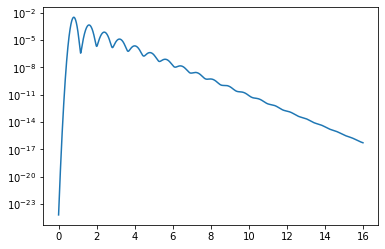

In [13]:
x_pdf = np.linspace(0, 20, 20000)
y_pdf = sipm_gentile_spe(x_pdf, 0.1, 0.2)

# Normalize
x_scale = np.average(x_pdf, weights=y_pdf)
y_scale = y_pdf.sum()
x_pdf /= x_scale
y_pdf /= y_scale

plt.semilogy(x_pdf, y_pdf)

## Step 2: Demonstration of Normal Use
If I wished to extract from this distribution for a single photosensor pixel, I can do the following:

Mean = 0.9994337476879047


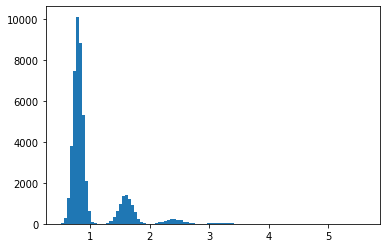

In [14]:
n_pe = 50000
charges = np.random.choice(x_pdf, size=(n_pe), p=y_pdf)
_ = plt.hist(charges, bins=100)
print(f"Mean = {charges.mean()}")

In [15]:
# Simple handling of n_pixels
n_pe = 500
n_pixels = 2048
charges = np.random.choice(x_pdf, size=(n_pixels, n_pe), p=y_pdf)
print(charges.shape)

(2048, 500)


The problem with the previous approach is that every pixel is specified with the same number of photoelectrons. This is rarely the case we want to simulate.

## Step 3: Alternative to np.random.choice
Normally in this situation, I would resort to numba, allowing me to perform an optimised for loop (or vectorization) across the pixels. However, this is not possible to do with `np.random.choice`, as the `p` option is not presently supported by numba:
https://github.com/numba/numba/issues/2539

However, also in the above issue, an alternative implementation is described. This approach uses the concept of ["Inverse Transform Sampling"](https://en.wikipedia.org/wiki/Inverse_transform_sampling), which is the technical term for what we are trying to achieve here. It transforms the Probability Density Function into its Cumulative Density Function (CFD), gets a random number between 0 and 1, finds the sample on the CDF that corresponds to the random number, and the returns the corresponding x value for that sample.

In [16]:
@njit
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

In [17]:
%timeit np.random.choice(x_pdf, p=y_pdf)
%timeit rand_choice_nb(x_pdf, y_pdf)

236 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
31.1 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Initial results are promising! The alternative implementation (when decorated with `@njit` is a factor of 10 faster than `np.random.choice`. Now we need to extend it to hand n_pe

In [18]:
y_cdf = np.cumsum(y_pdf)

In [19]:
np.searchsorted(y_cdf, np.random.random(100), side="right")

array([ 957, 1020, 1115,  897, 4357, 1067, 1064, 1011,  918, 1180, 1845,
       1021, 2246,  933, 1832, 1008, 1103, 1809, 2006,  987,  814, 1068,
       1902,  818, 1042,  925,  843, 1034, 1090, 1119, 1994,  991,  909,
       1018,  950, 1944, 1068,  855, 1083, 2899,  946,  965,  933, 1145,
       1165, 1920, 1052, 1606,  874, 1121,  999, 1108, 1011,  986, 3087,
       1042,  976,  885,  999, 1009,  735, 1126,  977,  942,  999,  986,
       1012, 1049,  955, 1074, 1888, 1128, 1059, 1073, 2133,  929, 2178,
       1120, 1037,  862, 1058, 1098,  932,  970,  907,  951,  974, 1177,
       1027, 2001, 1027,  984, 1044,  895, 3342, 2901, 1100,  650,  822,
        947])

In [20]:
@njit(fastmath=True)
def choice_nb_npe(x, n_pe, cdf):
    charges = x[np.searchsorted(cdf, np.random.random(n_pe), side="right")]
    return charges

Mean = 0.9981891414575925


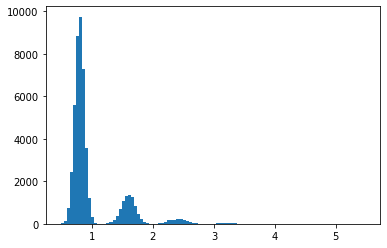

In [21]:
n_pe = 50000
charges = choice_nb_npe(x_pdf, n_pe, y_cdf)
_ = plt.hist(charges, bins=100)
print(f"Mean = {charges.mean()}")

In [22]:
np.logspace(1, 6, 2)

array([1.e+01, 1.e+06])

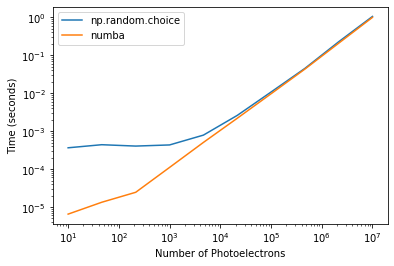

In [23]:
# Test scalabilty of methods

choice_nb_npe(x_pdf, 1, y_cdf) # ensure compiled

n_pe_array = np.logspace(1, 7, 10, dtype=np.int)
times_np = []
times_nb = []
for n_pe in n_pe_array:
    time_np = %timeit -q -o -r 1 -n 10 np.random.choice(x_pdf, size=n_pe, p=y_pdf)
    time_nb = %timeit -q -o -r 1 -n 10 choice_nb_npe(x_pdf, n_pe, y_cdf)
    times_np.append(time_np.average)
    times_nb.append(time_nb.average)
plt.plot(n_pe_array, times_np, label="np.random.choice")
plt.plot(n_pe_array, times_nb, label="numba")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Photoelectrons")
plt.ylabel("Time (seconds)")
plt.legend(loc='best')

Both algorithms are O(n log n) in complexity, with the numpy method containing an additional scalar constant runtime. This makes sense, as a delve into the source code of numpy reveals that they essentially use the same approach in the definition of `np.random.choice`:
https://github.com/numpy/numpy/blob/569dfcd79aeb2a584e008861e5e29b7b5115d94e/numpy/random/_generator.pyx#L661

Therefore our numba algorithm is a fair replacement for `np.random.choice`.

## Step 4: Sampling each pixel individually
Now that we have a working algorithm that we have full control over, lets address the original problem where we have a different charge per pixel:

In [24]:
n_pe = np.full(2048, 1, dtype=np.int)

In [25]:
@njit(fastmath=True)
def choice_nb_pixels(x, n_pe, cdf):
    n_pixels = n_pe.size
    charges = np.zeros(n_pixels)
    for ipix in range(n_pixels):
        charges[ipix] = x[np.searchsorted(cdf, np.random.random(n_pe[ipix]), side="right")].sum()
    return charges

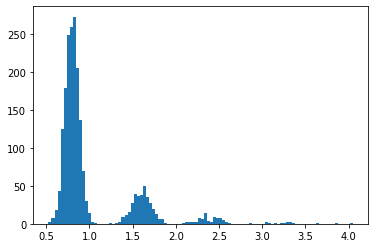

In [26]:
charges = choice_nb_pixels(x_pdf, n_pe, y_cdf)
_ = plt.hist(charges, bins=100)

In [27]:
@guvectorize([(float64[:], int64, float64[:], float64[:])], "(n),(),(n)->()", fastmath=True)
def choice_nb_pixels_vectorized(x, n_pe, cdf, ret):
    ret[0] = x[np.searchsorted(cdf, np.random.random(n_pe), side="right")].sum()

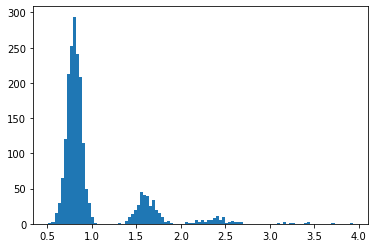

In [28]:
charges = choice_nb_pixels_vectorized(x_pdf, n_pe, y_cdf)
_ = plt.hist(charges, bins=100)

In [29]:
n_pe = np.full(2048, 100, dtype=np.int)
%timeit choice_nb_pixels(x_pdf, n_pe, y_cdf)
%timeit choice_nb_pixels_vectorized(x_pdf, n_pe, y_cdf)

21.2 ms ± 441 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.4 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
